**INITIALIZATION**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**LIBRARIES AND DEPENDENCIES**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [3]:
#@ INSTALLING DEPENDENCIES: UNCOMMENT BELOW: 
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [4]:
#@ DOWNLOADING LIBRARIES AND DEPENDENCIES: 
from fastbook import *                              # Getting all the Libraries. 
from fastai.callback.fp16 import *
from fastai.vision.all import *                     # Getting all the Libraries.
#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

**GETTING THE DATA**

In [6]:
#@ GETTING THE DATASET: 
path = untar_data(URLs.PETS)                              # Path to the Dataset. 
files = get_image_files(path/"images")                    # Getting Image Files.

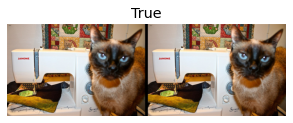

In [7]:
#@ CREATING SIAMESE IMAGE OBJECT: SUBCLASSES TUPLE: 
class SiameseImage(fastuple):                             # Defining Class. 
    def show(self, ctx=None, **kwargs):                   # Defining Function. 
        img1, img2, same_breed = self                     # Initialization. 
        if not isinstance(img1, Tensor):
            if img2.size != img1.size:                    # Inspecting Size. 
                img2 = img2.resize(img1.size)             # Resizing. 
            t1, t2 = tensor(img1), tensor(img2)           # Converting into Tensors. 
            t1, t2 = t1.permute(2,0,1),t2.permute(2,0,1)  # Changing Dimensions. 
        else: t1, t2 = img1, img2 
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2],dim=2), 
                          title=same_breed, ctx=ctx)      # Inspection. 

#@ IMPLEMENTATION OF SIAMESE IMAGE OBJECT: 
img = PILImage.create(files[0])                           # Getting an Image. 
s = SiameseImage(img, img, True)                          # Initializing Object. 
s.show();                                                 # Inspecting Image.

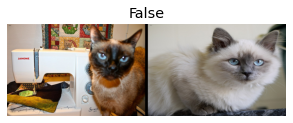

In [8]:
#@ FUNCTION FOR DETERMINING CLASSES: 
def label_func(fname):                                              # Defining Function. 
    return re.match(r"^(.*)_\d+.jpg$", fname.name).groups()[0]

#@ IMPLEMENTATION OF SIAMESE TRANSFORM OBJECT: 
class SiameseTransform(Transform):                                  # Defining Class. 
    def __init__(self, files, label_func, splits):                  # Constructor Function. 
        self.labels = files.map(label_func).unique()                # Getting Labels. 
        self.lbl2files = {l:L(f for f in files if label_func(f)==l)
                          for l in self.labels}
        self.label_func = label_func                                # Initializing Labels. 
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
    
    def encodes(self, f):                                           # Defining Function. 
        f2, t = self.valid.get(f, self._draw(f))
        img1, img2 = PILImage.create(f), PILImage.create(f2)        # Creating PIL Images. 
        return SiameseImage(img1, img2, t)                          # Implementation of Siamese Image. 

    def _draw(self, f):                                             # Defining Function. 
        same = random.random() < 0.5                   
        cls = self.label_func(f)                                    # Getting Labels. 
        if not same:
            cls=random.choice(L(l for l in self.labels if l!=cls))
        return random.choice(self.lbl2files[cls]), same

#@ IMPLEMENTATION OF SIAMESE TRANSFORM CLASS: 
splits = RandomSplitter()(files)                                    # Initializing Random Splitting. 
tfm = SiameseTransform(files, label_func, splits)                   # Initializing Siamese Transform. 
tfm(files[0]).show();                                               # Inspection.

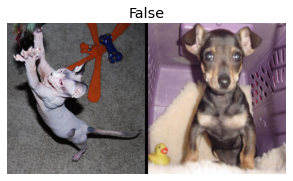

In [9]:
#@ IMPLEMENTATION OF TRANSFORMED COLLECTIONS: 
tls = TfmdLists(files, tfm, splits=splits)                          # Initializing Transformed Lists. 
show_at(tls.valid, 0);                                              # Inspection.

In [10]:
#@ CREATING DATALOADERS: 
dls = tls.dataloaders(after_item=[Resize(224), ToTensor],                       # Resizing and Creating Tensors. 
                      after_batch=[IntToFloatTensor, 
                                   Normalize.from_stats(*imagenet_stats)])      # Normalizing the Batches.

**BODY AND HEAD OF NETWORK**
- The head of a neural net is the part that is specialized for a particular task. For a **Convolutional Neural Network**, it's generally the part after the adaptive average pooling layer. The body of the neural net contains everything except the head of a network and also includes the stem of the network. 

In [11]:
#@ INSPECTING HEAD OF NETWORK: 
model_meta[resnet50]                                    # Inspecting Head of Network. 

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [12]:
#@ INSPECTING BODY OF NETWORK: 
create_head(20, 2)                                      # Inspecting Body of Network. 

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=40, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

**SIAMESE NETWORK**

In [13]:
#@ DEFINING THE SIAMESE NETWORK MODEL: 
class SiameseModel(Module):                                     # Defining Siamese Model. 
    def __init__(self, encoder, head):                          # Initializing Constructor Function. 
        self.encoder = encoder                                  # Initializing Pretrained Model. 
        self.head = head                                        # Initializing Head of Network.  
    
    def forward(self, x1, x2):                                  # Forward Propagation Function. 
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], 
                         dim=1)                                 # Implementation of Pretrained Model. 
        return self.head(ftrs)                                  # Implementation of Head of Network. 

**Note:**
- I will use pretrained model to create the encoder. The last layer of the encoder has 512 features so the head of the network will receive 512X4 features. Here 4 is used because there are 2 images and 2 for concatenation and pooling. 

In [15]:
#@ INITIALIZING ENCODER AND HEAD OF THE NETWORK:  
encoder = create_body(resnet34, cut=-2)                         # Initializing Encoder. 
head = create_head(512*2, 2, ps=0.5)                            # Initialiizng Head of Network. 
model = SiameseModel(encoder, head)                             # Building the Model. 

**LOSS FUNCTION**
- I will use the regular cross entropy loss function but since the targets are booleans, I will convert them to integers. 

In [16]:
#@ DEFINING LOSS FUNCTION:
def loss_func(out, targ):                                       # Defining Loss Function. 
    return nn.CrossEntropyLoss()(out, targ.long())              # Implementation of CrossEntropy. 

**SPLITTER FUNCTION**
- A splitter is a function that tells the fastai library how to split the model into parameter groups which are used to train only the head of the model during transfer learning. The **params** is just a function that returns all parameters of a given module. 

In [17]:
#@ DEFINING SPLITTER FUNCTION: 
def siamese_splitter(model):                                    # Defining Splitter Function. 
    return [params(model.encoder), params(model.head)]          # Splitting the Model. 

In [18]:
#@ INITIALIZING LEARNER: 
learn = Learner(dls, model, loss_func=loss_func,                # Initializing Model and Loss Function. 
                splitter=siamese_splitter, 
                metrics=accuracy).to_fp16()                     # Creating Learner. 
learn.freeze()                                                  # Initializing Freezing.  

In [19]:
#@ TRAINING THE HEAD OF NETWORK: 
learn.fit_one_cycle(4, 3e-3)                                    # Training the Model. 

epoch,train_loss,valid_loss,accuracy,time
0,0.563909,0.379712,0.843708,02:56
1,0.381631,0.243882,0.908660,02:56
2,0.302855,0.195179,0.928958,02:55
3,0.253781,0.177493,0.939107,02:55


In [20]:
#@ TRAINING THE NETWORK: TRANSFER LEARNING: 
learn.unfreeze()                                                # Unfreezing the Body of Network. 
learn.fit_one_cycle(4, slice(1e-6, 1e-4))                       # Training the Model. 

epoch,train_loss,valid_loss,accuracy,time
0,0.250375,0.173319,0.939107,04:07
1,0.226936,0.166663,0.942490,04:07
2,0.217743,0.167252,0.944520,04:07
3,0.223304,0.163282,0.946549,04:08


**Conclusion**
- Here completes how to create a state of art computer vision models. 

**TABULAR MODEL**

In [ ]:
#@ IMPLEMENTATION OF FORWARD METHOD FOR TABULAR MODEL: 
if self.n_emb != 0:
    x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]     # Getting Activations of Embedding Matrices. 
    x = torch.cat(x, 1)                                       # Initializing Concatenation. 
    x = self.emb_drop(x)                                      # Implementation of Dropout. 

if self.n_cont != 0:                                          # Inspecting Continuous Variables. 
    x_cont = self.bn_cont(x_cont)                             # Implementation of Batch Normalization. 
    x=torch.cat([x,x_cont],1) if self.n_emb != 0 else x_cont  # Concatenating with Embedding Matrices. 
return self.layers(x)